## Data Processing
- This notebook handles the data processing and train data creation part.
- It also saves metadata needed during inference.

### Import Libraries
- Import all essential libraries

In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
from tabulate import tabulate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import pickle
import warnings
warnings.filterwarnings('ignore')

### Data Loading
- Load data from excel sheet

In [2]:
#Load all 4 sheets
soc_dem_data = pd.read_excel('data/DataScientist_CaseStudy_Dataset.xlsx', sheet_name='Soc_Dem')
products_actBalance_data = pd.read_excel('data/DataScientist_CaseStudy_Dataset.xlsx', sheet_name='Products_ActBalance')
inflow_outflow_data = pd.read_excel('data/DataScientist_CaseStudy_Dataset.xlsx', sheet_name='Inflow_Outflow')
sales_revenues_data = pd.read_excel('data/DataScientist_CaseStudy_Dataset.xlsx', sheet_name='Sales_Revenues')

In [3]:
#Combined data of all the 3 excel sheets : Soc_Dem ,Products_ActBalance and Inflow_Outflow combined using client ID
combined_data= pd.concat([soc_dem_data.set_index('Client',inplace=False),products_actBalance_data.set_index('Client',inplace=False),inflow_outflow_data.set_index('Client',inplace=False)],axis=1,sort=False).reset_index()
combined_data.rename(columns = {'index':'Client'})
print(combined_data.head(2))
print("Combined Shape : ", combined_data.shape)

   Client Sex  Age  Tenure  Count_CA  Count_SA  Count_MF  Count_OVD  Count_CC  \
0     909   M   21      27         1       NaN       NaN        1.0       NaN   
1    1217   M   38     165         1       NaN       NaN        NaN       NaN   

   Count_CL  ...   VolumeDeb  VolumeDeb_CA  VolumeDebCash_Card  \
0       1.0  ...  450.678571    448.892857          178.571429   
1       NaN  ...  714.285714    714.285714            0.000000   

   VolumeDebCashless_Card  VolumeDeb_PaymentOrder  TransactionsDeb  \
0                     0.0              166.571429              8.0   
1                     0.0              714.285714              1.0   

   TransactionsDeb_CA  TransactionsDebCash_Card  TransactionsDebCashless_Card  \
0                 7.0                       1.0                           0.0   
1                 1.0                       0.0                           0.0   

   TransactionsDeb_PaymentOrder  
0                           4.0  
1                           1.0  


### Data Exploration
- In this section, the data will be analyzed to find issues, missing values and relations.
- Make needed changes for later processing

#### Handling Missing Values and Correction
- In this section will find the missing values and will fill it with appropriate values. 

In [4]:
# Find columns with missing values
print(combined_data.columns[combined_data.isna().any()].tolist())

['Sex', 'Count_SA', 'Count_MF', 'Count_OVD', 'Count_CC', 'Count_CL', 'ActBal_SA', 'ActBal_MF', 'ActBal_OVD', 'ActBal_CC', 'ActBal_CL', 'VolumeCred', 'VolumeCred_CA', 'TransactionsCred', 'TransactionsCred_CA', 'VolumeDeb', 'VolumeDeb_CA', 'VolumeDebCash_Card', 'VolumeDebCashless_Card', 'VolumeDeb_PaymentOrder', 'TransactionsDeb', 'TransactionsDeb_CA', 'TransactionsDebCash_Card', 'TransactionsDebCashless_Card', 'TransactionsDeb_PaymentOrder']


In [5]:
#Sex Column find the mod and fill the missing values. 
sex_mod = combined_data.Sex.mode()[0]
print("Most number of sex :", sex_mod)
combined_data['Sex'] = combined_data['Sex'].fillna(sex_mod)

Most number of sex : M


In [6]:
#'Count_SA', 'Count_MF', 'Count_OVD', 'Count_CC', 'Count_CL', 'ActBal_SA', 'ActBal_MF', 'ActBal_OVD', 'ActBal_CC', 'ActBal_CL'
#Analyzing the data, the empty values in this should be 0. So will fill all the empty values with 0
process_col_list = ["Count_SA","Count_MF","Count_OVD","Count_CC","Count_CL","ActBal_SA","ActBal_MF","ActBal_OVD","ActBal_CC","ActBal_CL"]
combined_data[process_col_list]=combined_data[process_col_list].fillna(0) 

In [7]:
#'VolumeCred', 'VolumeCred_CA', 'TransactionsCred', 'TransactionsCred_CA', 'VolumeDeb', 'VolumeDeb_CA', 'VolumeDebCash_Card', 'VolumeDebCashless_Card', 'VolumeDeb_PaymentOrder', 'TransactionsDeb', 'TransactionsDeb_CA', 'TransactionsDebCash_Card', 'TransactionsDebCashless_Card', 'TransactionsDeb_PaymentOrder'
#Check if client ID's not present in the transaction data
# Get values in 'col1' of df1 not present in 'col2' of df2
clients_with_no_transcation = soc_dem_data[~soc_dem_data['Client'].isin(inflow_outflow_data['Client'])]['Client']
clients_with_no_transcation.shape  # This is 28
combined_data.isna().sum() # This is 28

##Since this clients don't have any transacions. These client rows can be dropped from further processing.
combined_data.dropna(inplace=True)

In [8]:
# Check if any more missing values. Found no missing value
print(combined_data.columns[combined_data.isna().any()].tolist())

[]


In [9]:
# Convert Sex from string to numerical value.
combined_data['Sex']= combined_data['Sex'].replace(['M', 'F'],[0, 1])
print(combined_data['Sex'].head(3))

0    0
1    0
2    1
Name: Sex, dtype: int64


#### Data Correlation Analysis
- Find the correlation between features.

In [10]:
# Create correlation matrix
corr_matrix = combined_data.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
columns_name = list(upper.columns.values)
#Check the features which have more than 0.75 correlation.
correlation_upper_thresold =0.75
high_correlated_list=[]
for col in columns_name:
    for idx in range(len(columns_name)):
        if upper[col][idx]>correlation_upper_thresold:
            high_correlated_list.append([col,upper[col].index[idx],str(upper[col][idx])])
print(tabulate(high_correlated_list, headers=['Feature1', 'Feature2','CorrValue']))

Feature1                      Feature2              CorrValue
----------------------------  ------------------  -----------
VolumeCred_CA                 VolumeCred             0.93709
TransactionsCred_CA           TransactionsCred       0.947662
VolumeDeb                     VolumeCred             0.853392
VolumeDeb                     VolumeCred_CA          0.795244
VolumeDeb_CA                  VolumeCred             0.867303
VolumeDeb_CA                  VolumeCred_CA          0.822232
VolumeDeb_CA                  VolumeDeb              0.944994
VolumeDeb_PaymentOrder        VolumeDeb              0.829853
VolumeDeb_PaymentOrder        VolumeDeb_CA           0.838541
TransactionsDeb_CA            TransactionsDeb        0.918128
TransactionsDebCashless_Card  TransactionsDeb        0.800941
TransactionsDebCashless_Card  TransactionsDeb_CA     0.796987


- From the above table can see there is a high correlation between transaction features.
- Especially between account and CA account have very high correlation. So one can be dropped.
    - VolumeCred_CA VolumeCred 0.93709
    - TransactionsCred_CA TransactionsCred 0.947662
    - VolumeDeb_CA VolumeDeb 0.944994
    - TransactionsDeb_CA TransactionsDeb 0.918128
- Here can also observe there is a high correlation between Debit and credit.
    - VolumeDeb VolumeCred 0.853392, means higher debit, higher credit capacity and vice versa.

In [11]:
# Drop the CA columns as the other feature captures the overall flow of the accounts. 
#Drop VolumeCred_CA,TransactionsCred_CA,VolumeDeb_CA,TransactionsDeb_CA
combined_data = combined_data.drop(columns=['VolumeCred_CA','TransactionsCred_CA','VolumeDeb_CA','TransactionsDeb_CA'])
print(combined_data.columns.values)

['Client' 'Sex' 'Age' 'Tenure' 'Count_CA' 'Count_SA' 'Count_MF'
 'Count_OVD' 'Count_CC' 'Count_CL' 'ActBal_CA' 'ActBal_SA' 'ActBal_MF'
 'ActBal_OVD' 'ActBal_CC' 'ActBal_CL' 'VolumeCred' 'TransactionsCred'
 'VolumeDeb' 'VolumeDebCash_Card' 'VolumeDebCashless_Card'
 'VolumeDeb_PaymentOrder' 'TransactionsDeb' 'TransactionsDebCash_Card'
 'TransactionsDebCashless_Card' 'TransactionsDeb_PaymentOrder']


### Train and Test Data Creation
- In this section,the train and test data will be created from the sample data provided.

In [12]:
#First Combine the processed data with the given sample output. 
full_sample_data= pd.concat([combined_data.set_index('Client',inplace=False),sales_revenues_data.set_index('Client',inplace=False)],axis=1,sort=False).reset_index()
full_sample_data.rename(columns = {'index':'Client'})
#Remove Nan values, i.e. data with no result sample provided.
full_sample_data.dropna(inplace=True)
print("full data shape : " , full_sample_data.shape)
#Total of 951 data samples.

#From analysis Sale_XX column is a flag which shows revenue is created. So this columns can be dropped.
print(full_sample_data.head(2))

full data shape :  (951, 32)
   Client  Sex   Age  Tenure  Count_CA  Count_SA  Count_MF  Count_OVD  \
1    1217  0.0  38.0   165.0       1.0       0.0       0.0        0.0   
2     850  1.0  49.0    44.0       1.0       0.0       0.0        0.0   

   Count_CC  Count_CL  ...  TransactionsDeb  TransactionsDebCash_Card  \
1       0.0       0.0  ...              1.0                       0.0   
2       0.0       0.0  ...              6.0                       0.0   

   TransactionsDebCashless_Card  TransactionsDeb_PaymentOrder  Sale_MF  \
1                           0.0                           1.0      0.0   
2                           0.0                           1.0      0.0   

   Sale_CC  Sale_CL  Revenue_MF  Revenue_CC  Revenue_CL  
1      0.0      0.0         0.0    0.000000         0.0  
2      1.0      0.0         0.0    0.893929         0.0  

[2 rows x 32 columns]


#### Train and Test Data Split
- Below section drop the unnecessary sample revenue result columns and only include the necessary one.
- Create train and test data for the 3 models, 10 % test data and 90% train data
  - a. Consumer Loan, b. Credit Card and c. Mutual Fund models

Full Set :  (951, 27)
Train :  (855, 25) , (855, 2)
Test :  (96, 25) , (96, 2)


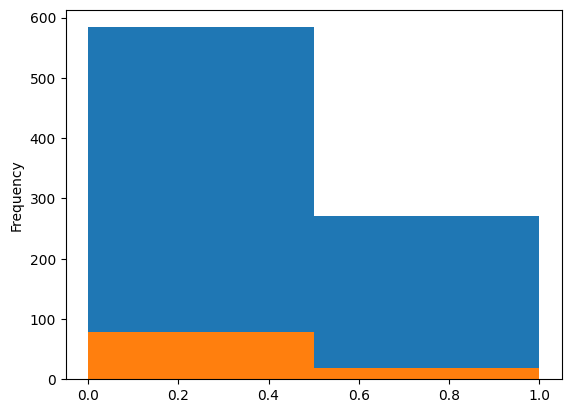

In [13]:
#Consumer Loan Dataset
consumer_loan_full_sample_data = full_sample_data.drop(columns=['Client','Revenue_MF','Revenue_CC','Sale_MF','Sale_CC'])
#consumer_loan_full_sample_data = consumer_loan_full_sample_data[consumer_loan_full_sample_data.Sale_CL != 0]
print("Full Set : ",consumer_loan_full_sample_data.shape)

consumer_loan_train, consumer_loan_test, consumer_loan_revenue_train, consumer_loan_revenue_test = train_test_split(consumer_loan_full_sample_data.drop(columns=['Revenue_CL','Sale_CL']), consumer_loan_full_sample_data[['Revenue_CL','Sale_CL']], test_size=0.10, random_state=42)
print("Train : ", consumer_loan_train.shape, ",",consumer_loan_revenue_train.shape)
print("Test : ", consumer_loan_test.shape, ",",consumer_loan_revenue_test.shape)

consumer_loan_revenue_train_classification = consumer_loan_revenue_train['Sale_CL']
consumer_loan_revenue_test_classification = consumer_loan_revenue_test['Sale_CL']
consumer_loan_revenue_train_classification.plot.hist(bins=2)
consumer_loan_revenue_test_classification.plot.hist(bins=2)

consumer_loan_revenue_train_revenue = consumer_loan_revenue_train['Revenue_CL']
consumer_loan_revenue_test_revenue = consumer_loan_revenue_test['Revenue_CL']

Full Set :  (951, 27)
Train :  (855, 25) , (855, 2)
Test :  (96, 25) , (96, 2)


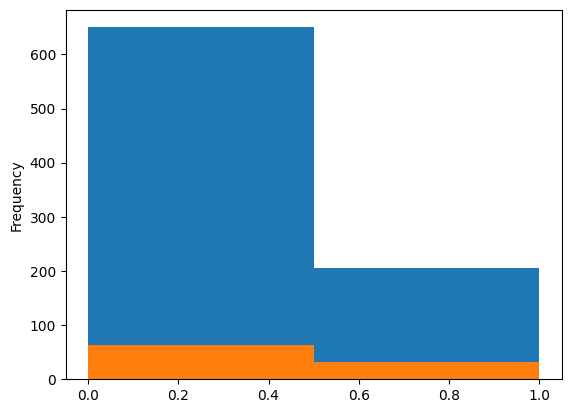

In [14]:
#Credit Card Dataset
credit_card_full_sample_data = full_sample_data.drop(columns=['Client','Revenue_MF','Revenue_CL','Sale_MF','Sale_CL'])
#credit_card_full_sample_data = credit_card_full_sample_data[credit_card_full_sample_data.Sale_CC != 0]
print("Full Set : ",credit_card_full_sample_data.shape)

credit_card_train, credit_card_test, credit_card_revenue_train, credit_card_revenue_test = train_test_split(credit_card_full_sample_data.drop(columns=['Revenue_CC','Sale_CC']), credit_card_full_sample_data[['Revenue_CC','Sale_CC']], test_size=0.10, random_state=42)
print("Train : ", credit_card_train.shape, ",",credit_card_revenue_train.shape)
print("Test : ", credit_card_test.shape, ",",credit_card_revenue_test.shape)

credit_card_revenue_train_classification = credit_card_revenue_train['Sale_CC']
credit_card_revenue_test_classification = credit_card_revenue_test['Sale_CC']
credit_card_revenue_train_classification.plot.hist(bins=2)
credit_card_revenue_test_classification.plot.hist(bins=2)

credit_card_revenue_train_revenue = credit_card_revenue_train['Revenue_CC']
credit_card_revenue_test_revenue = credit_card_revenue_test['Revenue_CC']


Full Set :  (951, 27)
Train :  (855, 25) , (855, 2)
Test :  (96, 25) , (96, 2)


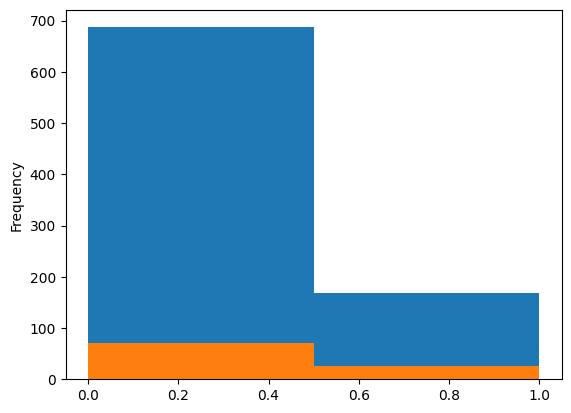

In [15]:
#Mutual Fund Dataset
mutual_fund_full_sample_data = full_sample_data.drop(columns=['Client','Revenue_CC','Revenue_CL','Sale_CC','Sale_CL'])
#mutual_fund_full_sample_data = mutual_fund_full_sample_data[mutual_fund_full_sample_data.Sale_MF != 0]
print("Full Set : ",credit_card_full_sample_data.shape)

mutual_fund_train, mutual_fund_test, mutual_fund_revenue_train, mutual_fund_revenue_test = train_test_split(mutual_fund_full_sample_data.drop(columns=['Revenue_MF','Sale_MF']), mutual_fund_full_sample_data[['Revenue_MF','Sale_MF']], test_size=0.10, random_state=42)
print("Train : ", mutual_fund_train.shape, ",",mutual_fund_revenue_train.shape)
print("Test : ", mutual_fund_test.shape, ",",mutual_fund_revenue_test.shape)

mutual_fund_revenue_train_classification = mutual_fund_revenue_train['Sale_MF']
mutual_fund_revenue_test_classification = mutual_fund_revenue_test['Sale_MF']
mutual_fund_revenue_train_classification.plot.hist(bins=2)
mutual_fund_revenue_test_classification.plot.hist(bins=2)

mutual_fund_revenue_train_revenue = mutual_fund_revenue_train['Revenue_MF']
mutual_fund_revenue_test_revenue = mutual_fund_revenue_test['Revenue_MF']


#### Starderdise Train and Test Data
- In this section the the train data will be starderdised and it will be stored for later inference.

In [16]:
columns_to_standerdize =['Sex', 'Age', 'Tenure', 'Count_CA', 'Count_SA', 'Count_MF',
       'Count_OVD', 'Count_CC', 'Count_CL', 'ActBal_CA', 'ActBal_SA',
       'ActBal_MF', 'ActBal_OVD', 'ActBal_CC', 'ActBal_CL', 'VolumeCred',
       'TransactionsCred', 'VolumeDeb', 'VolumeDebCash_Card',
       'VolumeDebCashless_Card', 'VolumeDeb_PaymentOrder', 'TransactionsDeb',
       'TransactionsDebCash_Card', 'TransactionsDebCashless_Card',
       'TransactionsDeb_PaymentOrder']

In [17]:
#Standerdise consumer loan data 
consumer_loan_scaler = StandardScaler()
consumer_loan_train[columns_to_standerdize] = consumer_loan_scaler.fit_transform(consumer_loan_train[columns_to_standerdize])
consumer_loan_test[columns_to_standerdize] = consumer_loan_scaler.transform(consumer_loan_test[columns_to_standerdize])

#Save scalar values for inference
with open('inference_metadata/consumer_loan_scaler.pkl','wb') as f:
    pickle.dump(consumer_loan_scaler, f)
# with open('file/path/scaler.pkl','rb') as f:
#     sc = pickle.load(f)

In [18]:
#Standerdise consumer loan data 
credit_card_scaler = StandardScaler()
credit_card_train[columns_to_standerdize] = credit_card_scaler.fit_transform(credit_card_train[columns_to_standerdize])
credit_card_test[columns_to_standerdize] = credit_card_scaler.transform(credit_card_test[columns_to_standerdize])

#Save scalar values for inference
with open('inference_metadata/credit_card_scaler.pkl','wb') as f:
    pickle.dump(credit_card_scaler, f)
# with open('file/path/scaler.pkl','rb') as f:
#     sc = pickle.load(f)

In [19]:
#Standerdise consumer loan data 
mutual_fund_scaler = StandardScaler()
mutual_fund_train[columns_to_standerdize] = mutual_fund_scaler.fit_transform(mutual_fund_train[columns_to_standerdize])
mutual_fund_test[columns_to_standerdize] = mutual_fund_scaler.transform(mutual_fund_test[columns_to_standerdize])

#Save scalar values for inference
with open('inference_metadata/mutual_fund_scaler.pkl','wb') as f:
    pickle.dump(mutual_fund_scaler, f)
# with open('file/path/scaler.pkl','rb') as f:
#     sc = pickle.load(f)

#### Feature selection uisng Recursive Feature Elimination
- In this section, I try to find the relevent features using feature elimination method to remove non required features.

Consumer Loan selected Features:  Index(['Age', 'Tenure', 'ActBal_CA', 'ActBal_SA', 'VolumeCred',
       'TransactionsCred', 'VolumeDeb', 'VolumeDebCash_Card',
       'VolumeDebCashless_Card', 'VolumeDeb_PaymentOrder', 'TransactionsDeb',
       'TransactionsDebCash_Card', 'TransactionsDebCashless_Card',
       'TransactionsDeb_PaymentOrder'],
      dtype='object')
Credit Card selected Features:  Index(['Age', 'Tenure', 'ActBal_CA', 'ActBal_SA', 'VolumeCred',
       'TransactionsCred', 'VolumeDeb', 'VolumeDebCash_Card',
       'VolumeDebCashless_Card', 'VolumeDeb_PaymentOrder', 'TransactionsDeb',
       'TransactionsDebCash_Card', 'TransactionsDebCashless_Card',
       'TransactionsDeb_PaymentOrder'],
      dtype='object')
Mutual Fund selected Features:  Index(['Age', 'Tenure', 'Count_MF', 'ActBal_CA', 'ActBal_SA', 'VolumeCred',
       'TransactionsCred', 'VolumeDeb', 'VolumeDebCash_Card',
       'VolumeDebCashless_Card', 'VolumeDeb_PaymentOrder', 'TransactionsDeb',
       'Transactions

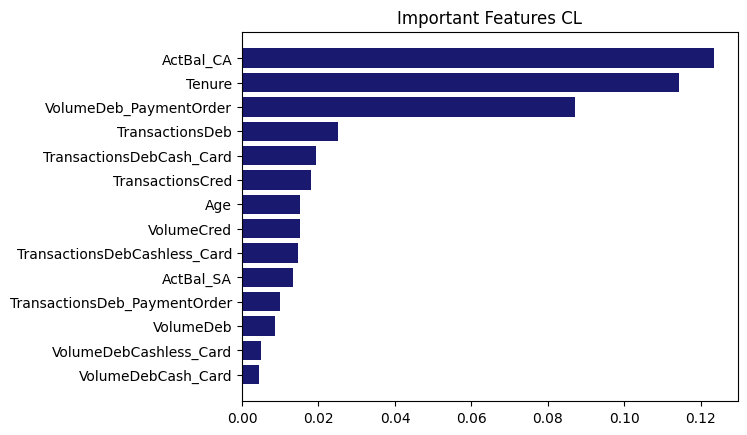

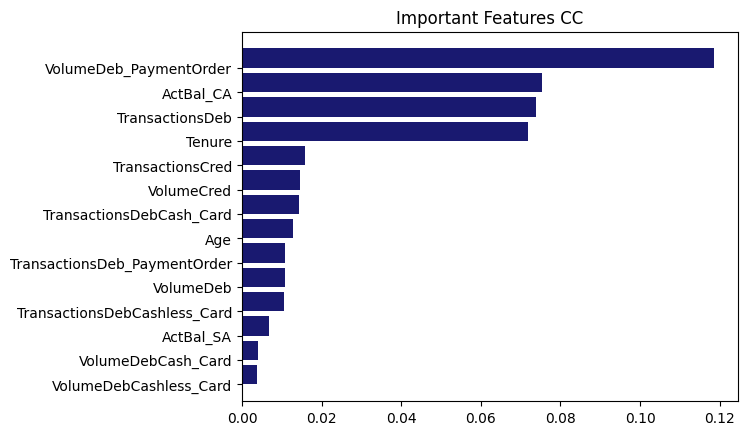

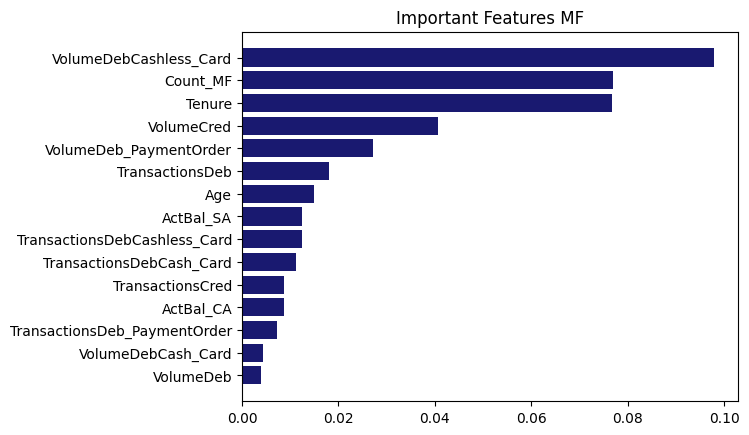

Consumer Loan selected Features:  ['Age', 'Tenure', 'ActBal_CA', 'ActBal_SA', 'VolumeCred', 'TransactionsCred', 'VolumeDeb', 'VolumeDebCash_Card', 'VolumeDebCashless_Card', 'VolumeDeb_PaymentOrder', 'TransactionsDeb', 'TransactionsDebCash_Card', 'TransactionsDebCashless_Card', 'TransactionsDeb_PaymentOrder']
Credit Card selected Features:  ['Age', 'Tenure', 'ActBal_CA', 'ActBal_SA', 'VolumeCred', 'TransactionsCred', 'VolumeDeb', 'VolumeDebCash_Card', 'VolumeDebCashless_Card', 'VolumeDeb_PaymentOrder', 'TransactionsDeb', 'TransactionsDebCash_Card', 'TransactionsDebCashless_Card', 'TransactionsDeb_PaymentOrder']
Mutual Fund selected Features:  ['Age', 'Tenure', 'Count_MF', 'ActBal_CA', 'ActBal_SA', 'VolumeCred', 'TransactionsCred', 'VolumeDeb', 'VolumeDebCash_Card', 'VolumeDebCashless_Card', 'VolumeDeb_PaymentOrder', 'TransactionsDeb', 'TransactionsDebCash_Card', 'TransactionsDebCashless_Card', 'TransactionsDeb_PaymentOrder']


In [20]:
CL_SelectFeature = SelectFromModel(RandomForestClassifier(n_estimators=500),threshold=0.02)
CL_SelectFeature.fit(consumer_loan_train, consumer_loan_revenue_train_classification)

CC_SelectFeature = SelectFromModel(RandomForestClassifier(n_estimators=500), threshold=0.02)
CC_SelectFeature.fit(credit_card_train, credit_card_revenue_train_classification)

MF_SelectFeature = SelectFromModel(RandomForestClassifier(n_estimators=500), threshold=0.02)
MF_SelectFeature.fit(mutual_fund_train, mutual_fund_revenue_train_classification)


selected_feature_CL = consumer_loan_train.columns[(CL_SelectFeature.get_support())]
print("Consumer Loan selected Features: " , selected_feature_CL)

selected_feature_CC = credit_card_train.columns[(CC_SelectFeature.get_support())]
print("Credit Card selected Features: " , selected_feature_CC)

selected_feature_MF = mutual_fund_train.columns[(MF_SelectFeature.get_support())]
print("Mutual Fund selected Features: " , selected_feature_MF)

plt.title('Important Features CL')
f_i = list(zip(selected_feature_CL, CL_SelectFeature.estimator_.feature_importances_))
f_i.sort(key = lambda x : x[1])
plt.barh([x[0] for x in f_i],[x[1] for x in f_i], color='midnightblue', align='center')
plt.show()

plt.title('Important Features CC')
f_i = list(zip(selected_feature_CC, CC_SelectFeature.estimator_.feature_importances_))
f_i.sort(key = lambda x : x[1])
plt.barh([x[0] for x in f_i],[x[1] for x in f_i], color='midnightblue', align='edge')
plt.show()


plt.title('Important Features MF')
f_i = list(zip(selected_feature_MF, MF_SelectFeature.estimator_.feature_importances_))
f_i.sort(key = lambda x : x[1])
plt.barh([x[0] for x in f_i],[x[1] for x in f_i], color='midnightblue', align='center')
plt.show()


CL_Selected_Cols = list(selected_feature_CL)
print("Consumer Loan selected Features: " , CL_Selected_Cols)

CC_Selected_Cols = list(selected_feature_CC)
print("Credit Card selected Features: " , CC_Selected_Cols)

MF_Selected_Cols = list(selected_feature_MF)
print("Mutual Fund selected Features: " , MF_Selected_Cols)

In [21]:
# Add only selected columsn for further training. Rest of the features are discarded for each train and test set
consumer_loan_train = consumer_loan_train[CL_Selected_Cols]
consumer_loan_test = consumer_loan_test[CL_Selected_Cols]

with open('inference_metadata/CL_Selected_Cols.pkl','wb') as f:
    pickle.dump(CL_Selected_Cols, f)

credit_card_train=credit_card_train[CC_Selected_Cols]
credit_card_test=credit_card_test[CC_Selected_Cols]

with open('inference_metadata/CC_Selected_Cols.pkl','wb') as f:
    pickle.dump(CC_Selected_Cols, f)

mutual_fund_train=mutual_fund_train[MF_Selected_Cols]
mutual_fund_test=mutual_fund_test[MF_Selected_Cols]

with open('inference_metadata/MF_Selected_Cols.pkl','wb') as f:
    pickle.dump(MF_Selected_Cols, f)

#### Feature selection using PCA
- For the 3 datasets, PCA analysis is done and n_componenets capturing 90% of variance is selected.

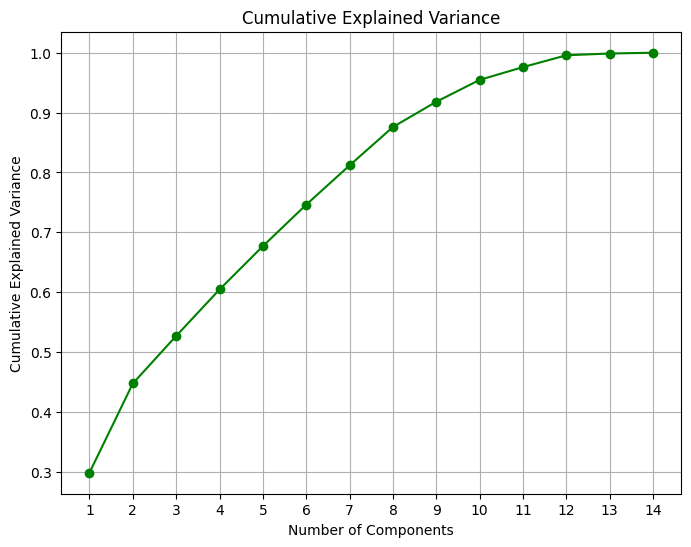

Number of components that explain at least 90% variance: 9


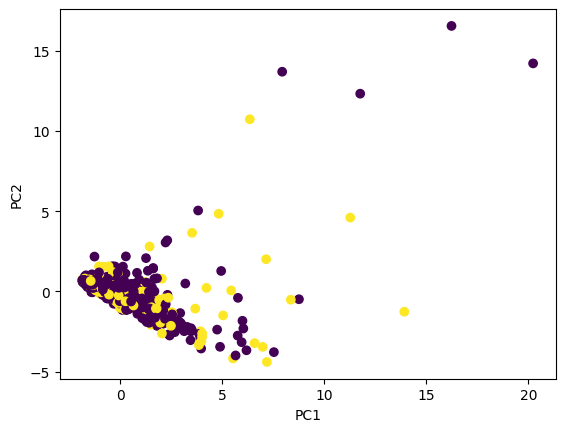

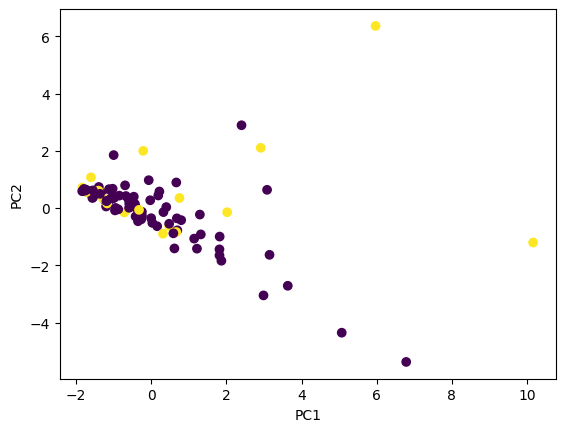

In [22]:
#PCA Analysis of consumer_loan and transform
consumer_loan_pca = PCA()
consumer_loan_pca.fit(consumer_loan_train)

explained_variance = consumer_loan_pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance)

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', color='green')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance')
plt.xticks(range(1, len(cumulative_explained_variance) + 1))
plt.grid(True)
plt.show()

n_components_90 = np.argmax(cumulative_explained_variance >= 0.90) + 1  # Adding 1 to account for 0-based index
# Output the number of components required to explain at least 90% variance
print(f"Number of components that explain at least 90% variance: {n_components_90}")

consumer_loan_pca = PCA(n_components = n_components_90)
consumer_loan_train = consumer_loan_pca.fit_transform(consumer_loan_train)
#Transform the test data with train data fitted.
consumer_loan_test = consumer_loan_pca.transform(consumer_loan_test)

#Save PCA for future analysis
with open('inference_metadata/consumer_loan_pca.pkl','wb') as f:
    pickle.dump(consumer_loan_pca, f)

plt.scatter(consumer_loan_train[:,0], consumer_loan_train[:,1], c = consumer_loan_revenue_train_classification)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

plt.scatter(consumer_loan_test[:,0], consumer_loan_test[:,1], c = consumer_loan_revenue_test_classification)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

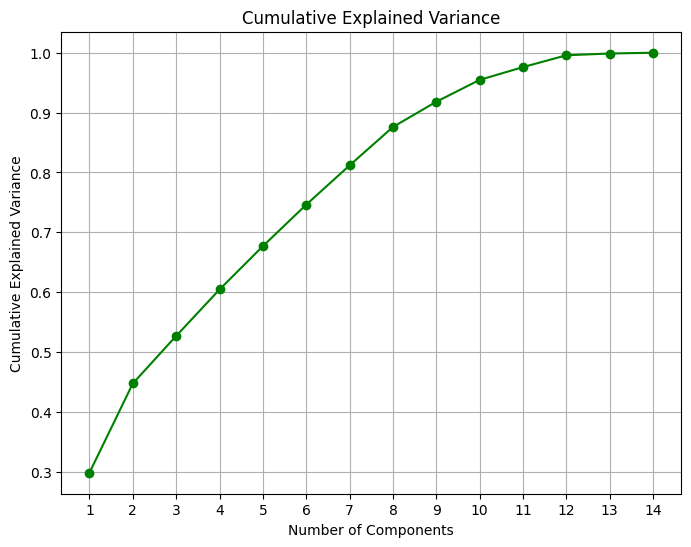

Number of components that explain at least 90% variance: 9


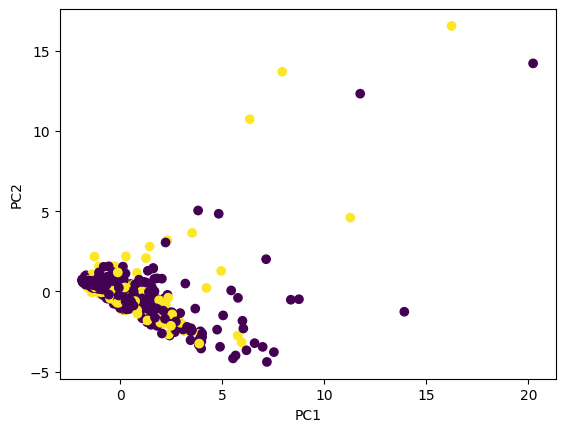

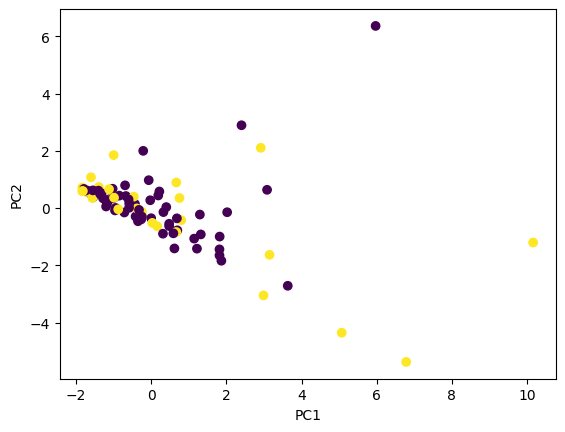

In [23]:
#PCA Analysis of credit_card and transform
credit_card_pca = PCA()
credit_card_pca.fit(credit_card_train)

explained_variance = credit_card_pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance)

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', color='green')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance')
plt.xticks(range(1, len(cumulative_explained_variance) + 1))
plt.grid(True)
plt.show()

n_components_90 = np.argmax(cumulative_explained_variance >= 0.90) + 1  # Adding 1 to account for 0-based index
# Output the number of components required to explain at least 90% variance
print(f"Number of components that explain at least 90% variance: {n_components_90}")

credit_card_pca = PCA(n_components = n_components_90)
credit_card_train = credit_card_pca.fit_transform(credit_card_train)
#Transform the test data with train data fitted.
credit_card_test = credit_card_pca.transform(credit_card_test)

#Save PCA for future analysis
with open('inference_metadata/credit_card_pca.pkl','wb') as f:
    pickle.dump(credit_card_pca, f)

plt.scatter(credit_card_train[:,0], credit_card_train[:,1], c = credit_card_revenue_train_classification)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

plt.scatter(credit_card_test[:,0], credit_card_test[:,1], c = credit_card_revenue_test_classification)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

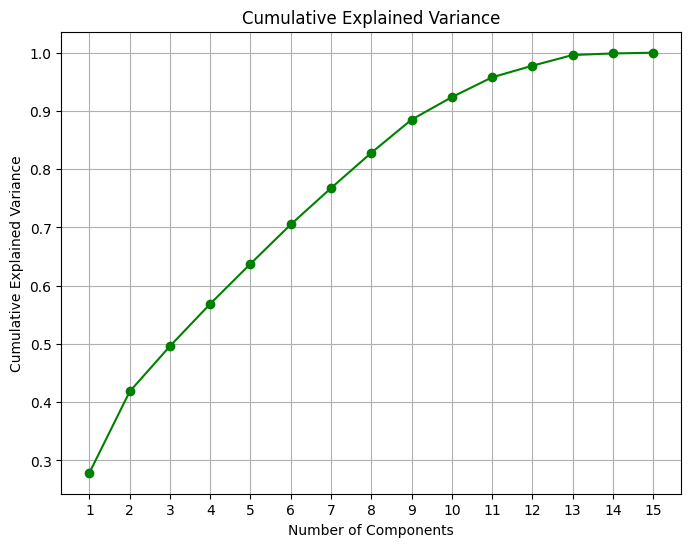

Number of components that explain at least 90% variance: 10


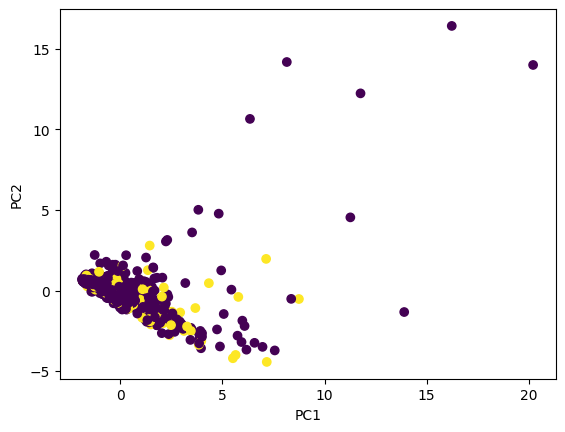

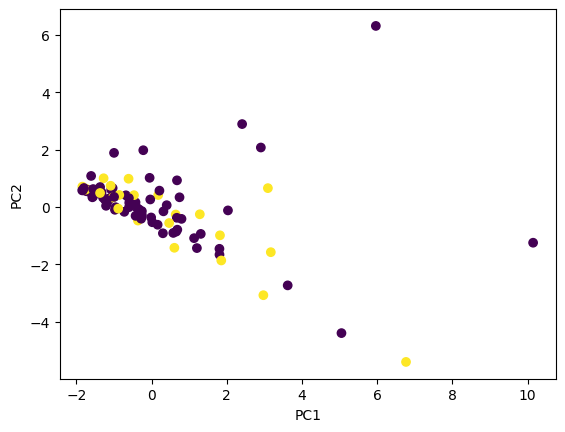

In [24]:
#PCA Analysis of credit_card and transform
mutual_fund_pca = PCA()
mutual_fund_pca.fit(mutual_fund_train)

explained_variance = mutual_fund_pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance)

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', color='green')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance')
plt.xticks(range(1, len(cumulative_explained_variance) + 1))
plt.grid(True)
plt.show()

n_components_90 = np.argmax(cumulative_explained_variance >= 0.90) + 1  # Adding 1 to account for 0-based index
# Output the number of components required to explain at least 90% variance
print(f"Number of components that explain at least 90% variance: {n_components_90}")

mutual_fund_pca = PCA(n_components = n_components_90)
mutual_fund_train = mutual_fund_pca.fit_transform(mutual_fund_train)
#Transform the test data with train data fitted.
mutual_fund_test = mutual_fund_pca.transform(mutual_fund_test)

#Save PCA for future analysis
with open('inference_metadata/mutual_fund_pca.pkl','wb') as f:
    pickle.dump(mutual_fund_pca, f)

plt.scatter(mutual_fund_train[:,0], mutual_fund_train[:,1], c =  mutual_fund_revenue_train_classification)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

plt.scatter(mutual_fund_test[:,0], mutual_fund_test[:,1], c = mutual_fund_revenue_test_classification)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

- Analyzing the first 2 componenets of PCA, cannot see a clear distinction between the positive and negative classes for all 3 model datases.

#### Save Train and Test Data
- Saves the dataset to train and test. 

In [25]:
# Save consumer_loan dataset
pd.DataFrame(consumer_loan_train).to_csv('processed_dataset_to_train/consumer_loan_train.csv', index=False, header=False)
consumer_loan_revenue_train_classification.to_csv('processed_dataset_to_train/consumer_loan_revenue_train_classification.csv', index=False, header=False)
consumer_loan_revenue_train_revenue.to_csv('processed_dataset_to_train/consumer_loan_revenue_train_revenue.csv', index=False, header=False)

pd.DataFrame(consumer_loan_test).to_csv('processed_dataset_to_train/consumer_loan_test.csv', index=False, header=False)
consumer_loan_revenue_test_classification.to_csv('processed_dataset_to_train/consumer_loan_revenue_test_classification.csv', index=False, header=False)
consumer_loan_revenue_test_revenue.to_csv('processed_dataset_to_train/consumer_loan_revenue_test_revenue.csv', index=False, header=False)

In [26]:
# Save credit_card dataset
pd.DataFrame(credit_card_train).to_csv('processed_dataset_to_train/credit_card_train.csv', index=False, header=False)
credit_card_revenue_train_classification.to_csv('processed_dataset_to_train/credit_card_revenue_train_classification.csv', index=False, header=False)
credit_card_revenue_train_revenue.to_csv('processed_dataset_to_train/credit_card_revenue_train_revenue.csv', index=False, header=False)

pd.DataFrame(credit_card_test).to_csv('processed_dataset_to_train/credit_card_test.csv', index=False, header=False)
credit_card_revenue_test_classification.to_csv('processed_dataset_to_train/credit_card_revenue_test_classification.csv', index=False, header=False)
credit_card_revenue_test_revenue.to_csv('processed_dataset_to_train/credit_card_revenue_test_revenue.csv', index=False, header=False)

In [27]:
# Save mutual_fund dataset
pd.DataFrame(mutual_fund_train).to_csv('processed_dataset_to_train/mutual_fund_train.csv', index=False, header=False)
mutual_fund_revenue_train_classification.to_csv('processed_dataset_to_train/mutual_fund_revenue_train_classification.csv', index=False, header=False)
mutual_fund_revenue_train_revenue.to_csv('processed_dataset_to_train/mutual_fund_revenue_train_revenue.csv', index=False, header=False)

pd.DataFrame(mutual_fund_test).to_csv('processed_dataset_to_train/mutual_fund_test.csv', index=False, header=False)
mutual_fund_revenue_test_classification.to_csv('processed_dataset_to_train/mutual_fund_revenue_test_classification.csv', index=False, header=False)
mutual_fund_revenue_test_revenue.to_csv('processed_dataset_to_train/mutual_fund_revenue_test_revenue.csv', index=False, header=False)